# Project 4: Cd-Aufnahme über die Nahrung bei Folsomia

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
from scipy import stats
import pandas as pd
from copy import deepcopy
import pprint
pp = pprint.PrettyPrinter(indent=2)
import os
import pyarrow

current_dir = os.path.dirname(os.path.abspath(''))
project_directory = os.path.dirname(current_dir)

# automatische aktualisierung externer Python-Dateien
%load_ext autoreload
%autoreload 2 

# Einbindung zusätzlicher Funktionen 
from utils import * 
from ModelFitting import *
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

## Start by fitting the model to control data

In [4]:
from DEBfitting_Folsomia import *
data = load_data()
data.head()

,t_day,length_mm,C_F,T_cels,S
85,0,0.609,0,20,1.420620
86,2,0.723,0,20,1.999511
87,4,0.857,0,20,2.805551
88,7,1.019,0,20,3.960986
89,9,1.095,0,20,4.571232


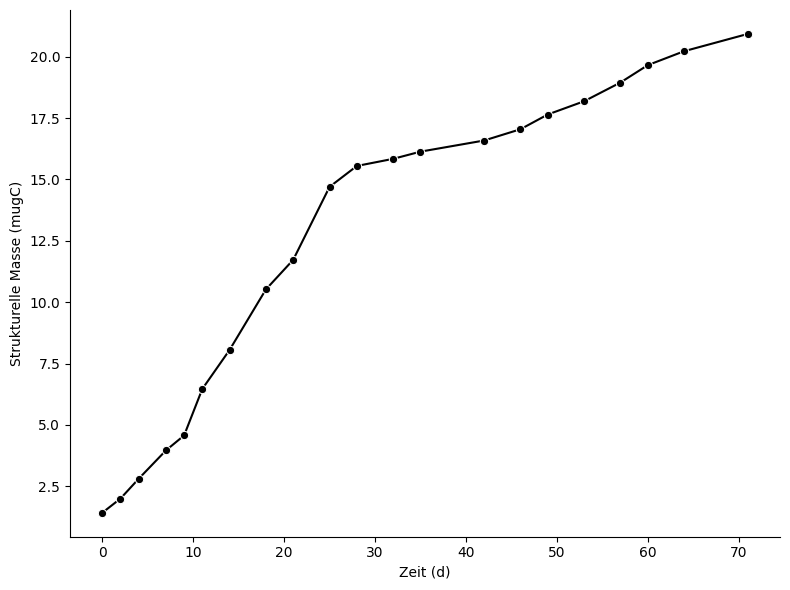

In [5]:
_ = plot_data(data)

c:\Users\Felix\projects\mem25\project\mempyDEB\DEBfitting_Folsomia.py:88: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5483797877675745), 'eta_AS_0': np.float64(0.40638832287776183)}


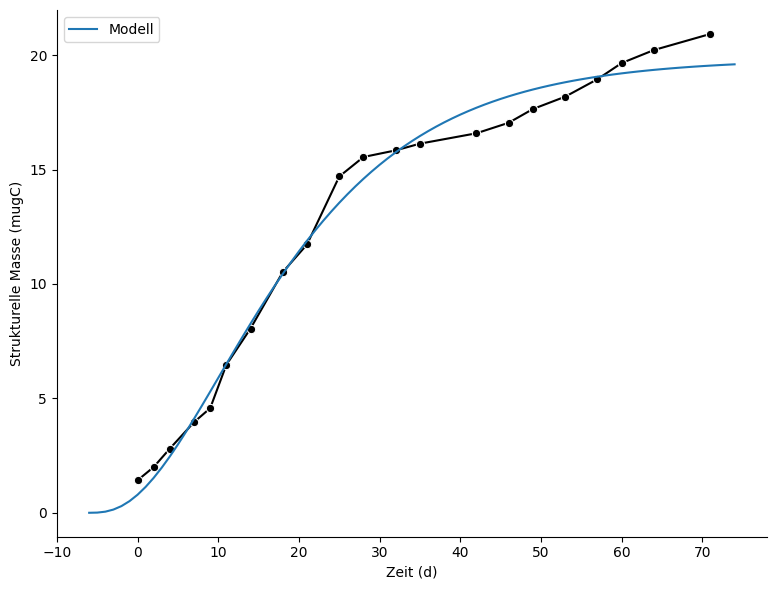

In [6]:
f = fit_model()

c:\Users\Felix\projects\mem25\project\mempyDEB\DEBfitting_Folsomia.py:88: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5483797877675745), 'eta_AS_0': np.float64(0.40638832287776183)}


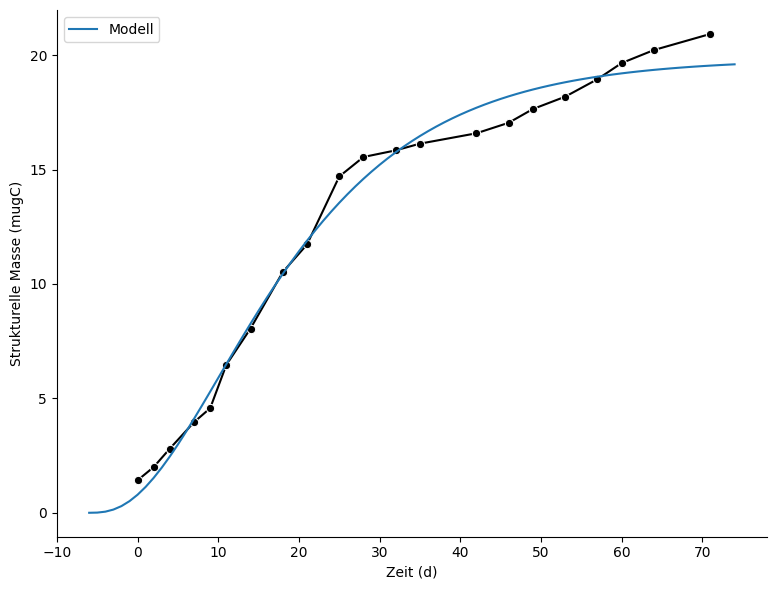

In [7]:
def fit_model_2params():
    """
    DEB-Modellkalibrierung mit zwei Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    f = setup_modelfit() 
    
    # wir müssen hier lediglich den initial guess anpassen
    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'eta_AS_0' : f.defaultparams.spc['eta_AS_0']
    }

    # am restlichen Code ändert sich ersmtal nichts

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax, label = "Modell")
    #sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    #ax[1].legend()

    return f
 
f_2params = fit_model_2params()

control_fitted_params = f_2params.p_opt


In [6]:
#control_fitted_params
f_2params

ModelFit(data=     t_day  length_mm  C_F  T_cels          S  S_scaled
85       0   0.609000    0      20   1.420620  0.067888
86       2   0.723000    0      20   1.999511  0.095551
87       4   0.857000    0      20   2.805551  0.134070
88       7   1.019000    0      20   3.960986  0.189285
89       9   1.095000    0      20   4.571232  0.218447
90      11   1.303000    0      20   6.463825  0.308889
91      14   1.455000    0      20   8.052735  0.384818
92      18   1.664000    0      20  10.521017  0.502771
93      21   1.757000    0      20  11.724806  0.560297
94      25   1.968000    0      20  14.696648  0.702313
95      28   2.024444    0      20  15.548253  0.743009
96      32   2.043333    0      20  15.838573  0.756883
97      35   2.062222    0      20  16.131567  0.770884
98      42   2.091111    0      20  16.584849  0.792545
99      46   2.120000    0      20  17.044385  0.814505
100     49   2.157143    0      20  17.644408  0.843179
101     53   2.190000    0      20

### Bayesian Inference

In [7]:
# f.define_lognorm_prior()
# f.run_bayesian_inference(
#     popsize = 35,
#     max_total_nr_simulations = 1_000)

In [8]:
# f.retrodict()
# fig,ax = plot_data(f.data)

# for df in f.retrodictions:
    
#     sns.lineplot(df, x = 't_day', y = 'S', ax = ax, alpha = .2, color = 'gray')

## use control fit to fit TKTD model

In [8]:
from TKTDFitting_Folsomia import *
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

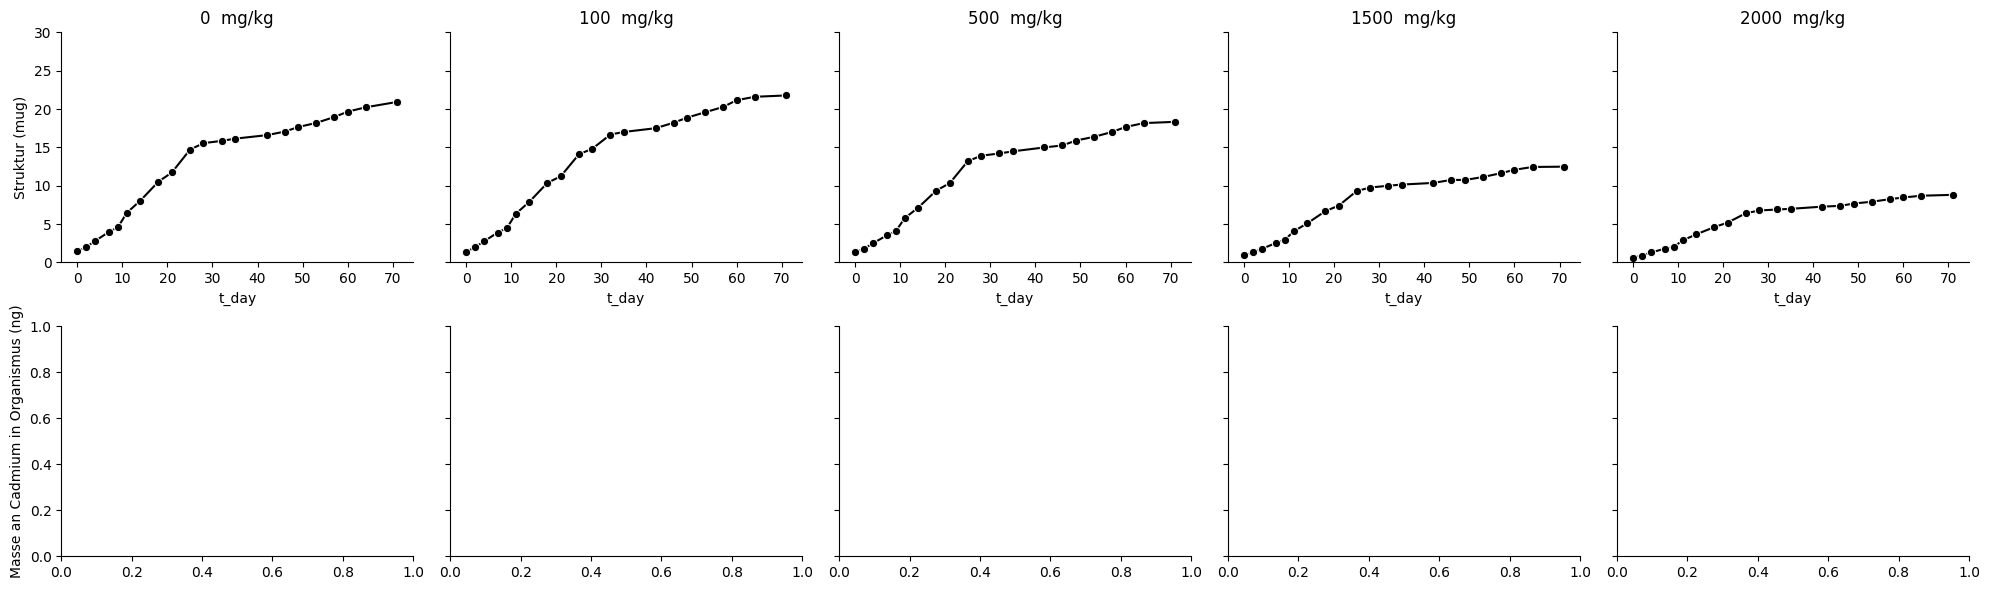

In [9]:
data = load_data()
fig, ax = plot_data(data)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(0.02187037037037036), 'ED50_j': np.float64(68.51851851851859), 'beta_j': np.float64(2.3333333333333313)}


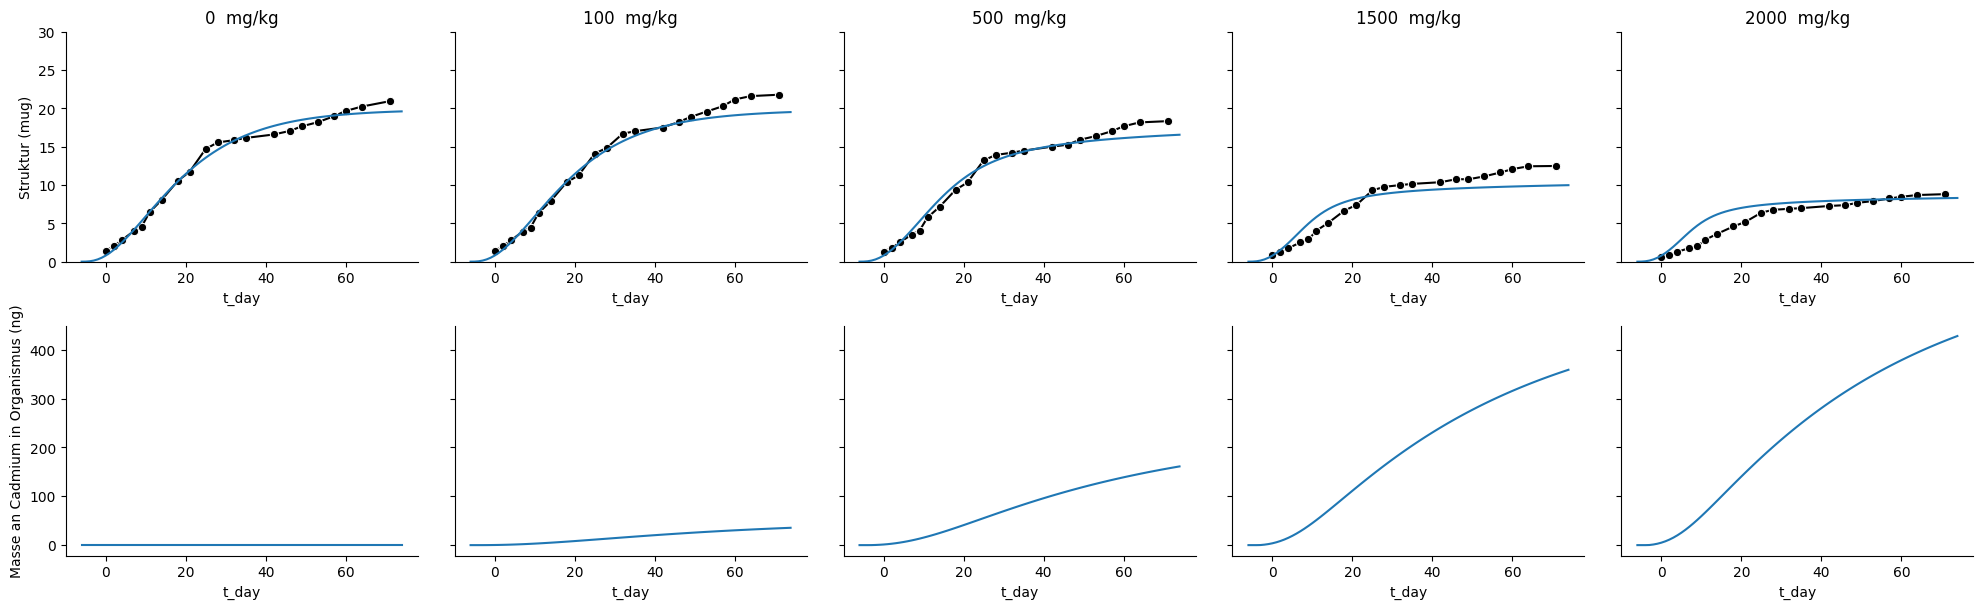

In [18]:
f = setup_modelfit(pmoa = 'G', func = simulate_DEBBase_cd_export)
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 0.02,
        'ED50_j' : 100, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(options={'maxiter' : 10}) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

In [12]:
f = setup_modelfit(pmoa = 'G')
f.defaultparams.spc.update(control_fitted_params)
print(f.defaultparams)
f.intguess = {
        'ED50_j' : 1000,
        'beta_j' : 2.
        }
sim = f.run_optimization(options={'maxiter' : 10}) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

Params(glb={'C_W': 0.0, 'V_patch': 0.05, 'Xdot_in': 10000000000.0, 'a_int': 6, 'tspan': (0, 80), 'Cd_food': 0.0}, spc={'X_emb_int': 19.42, 'eta_IA_0': 0.3333333333333333, 'eta_AS_0': np.float64(0.40638832287776183), 'eta_AR_0': 0.95, 'Idot_max_rel': np.float64(4.5483797877675745), 'Idot_max_rel_emb': 12.256744759847304, 'K_X': 500.0, 'kappa': 0.9, 'eta_SA': 0.9, 'k_M_0': np.float64(0.5039684199579493), 'S_p': 258.93333333333334, 'ex_cd': 0.02, 'kD_j': 0.5, 'ED50_j': 1.0, 'beta_j': 2.0, 'pmoa': 'G', 'kD_h': 0.5, 'ED50_h': 2.0, 'beta_h': 1.0})


KeyboardInterrupt: 

[np.float64(0.1571133271421053), np.float64(0.15915390699109527), np.float64(0.16168055287454206), np.float64(0.16482802403099925), np.float64(0.16877932919808628), np.float64(0.17378870262459378), np.float64(0.180217407038767), np.float64(0.18859045925493612), np.float64(0.19968767953378397), np.float64(0.21468798222307725), np.float64(0.23539258351313222), np.float64(0.26454619208469604), np.float64(0.30623210326342554), np.float64(0.3661750583106373), np.float64(0.45149215686197425), np.float64(0.5690747811503961), np.float64(0.7219067996907895), np.float64(0.9041226564572193), np.float64(1.0982554307349792), np.float64(1.2786603602284117), np.float64(1.4202757801814625), np.float64(1.5064412072218416), np.float64(1.53139884801248), np.float64(1.4987737023921972), np.float64(1.4186014523279145), np.float64(1.303847186663316), np.float64(1.1672652130949157), np.float64(1.0196483160551684), np.float64(0.8694864346726002), np.float64(0.7233774753226938), np.float64(0.5861479143382194),

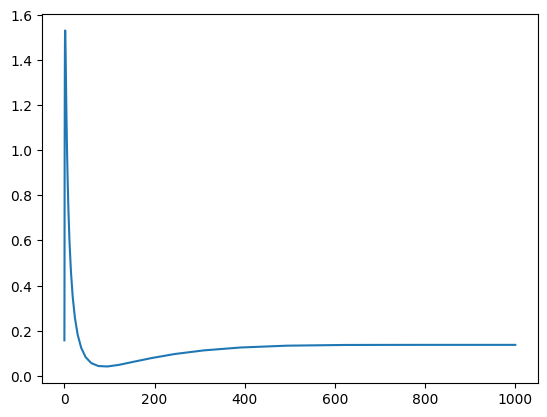

In [11]:
# x = np.geomspace(1, np.median(EXPOSURES))
#x = np.linspace(0.01, 4)
x = np.geomspace(0.01, 1000)
arr = []
f = setup_modelfit()
f.defaultparams.spc.update(control_fitted_params)
for i in x:
    f.intguess = {
            'ED50_j' : i,
            'beta_j' : i,
            'kD_j' : i
            }
    sim = f.simulator(f.intguess)
    arr.append(f.loss(sim, f.data))

print(arr)
fig, ax = plt.subplots()
ax.plot(x, arr)



In [16]:
sim_opt = sim_opt.assign(cd_conc  = lambda df : df.Cd_in / df.S)
sim_opt

,t_day,C_W,level_2,S,R,X_emb,X,Cd_in,cum_repro,cd_conc,S_ref,R_ref,X_emb_ref,X_ref,Cd_in_ref,C_W_ref,cum_repro_ref,cd_conc_ref,y_S
0,-6,0,0,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,0.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
1,-6,100,81,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,48.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
2,-6,500,162,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,47.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
3,-6,1500,243,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,34.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
4,-6,2000,324,0.000010,0.000000,9.924165e-01,1.000000e+10,0.000000,0.0,0.000000,0.00001,0.000000,0.992416,1.000000e+10,0.0,0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,74,0,80,19.598500,48.949572,-1.128662e-05,7.831235e+11,0.000000,47.0,0.000000,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,1.000000
401,74,100,161,19.365659,48.163759,-1.099085e-05,7.831235e+11,368.577319,46.0,19.032521,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.988119
402,74,500,242,15.906008,35.369349,-5.300900e-07,7.831236e+11,1630.197862,33.0,102.489441,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.811593
403,74,1500,323,9.783933,0.000000,-9.619439e-07,7.831236e+11,3651.196669,0.0,373.182932,19.59850,48.949572,-0.000011,7.831235e+11,0.0,0,47.0,0.0,0.499218


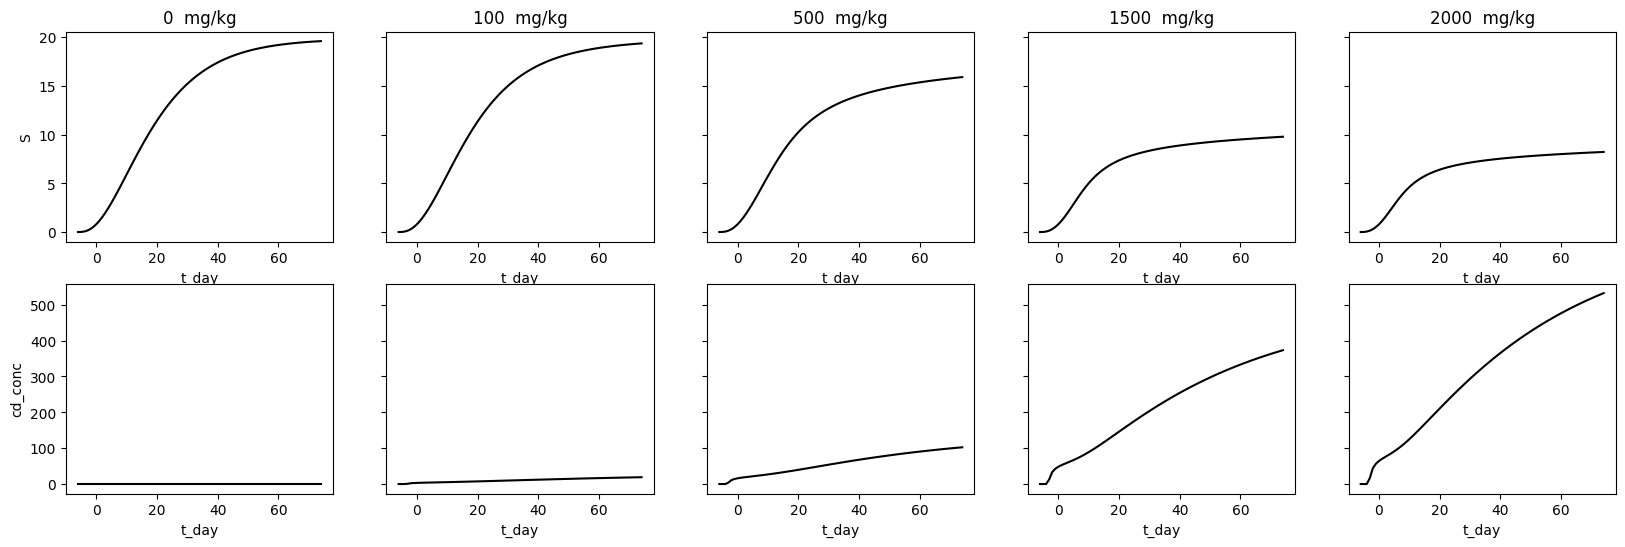

In [15]:
fig, ax = plt.subplots(ncols = 5, nrows=2, figsize = (20,6), sharey = 'row')

for (i,C_W) in enumerate(sim_opt.C_W.unique()):

    ax[0,i].set(title = f'{C_W}  mg/kg')
    obs = sim_opt.loc[lambda df : df.C_W==C_W]
    
    sns.lineplot(obs, x = 't_day', y = 'S', ax = ax[0,i], color = 'black')
    sns.lineplot(obs, x = 't_day', y = 'cd_conc', ax = ax[1,i], color = 'black')
    

## trying out different PMoA

Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'ex_cd': np.float64(0.02500000000000001), 'ED50_j': np.float64(500.0), 'beta_j': np.float64(1.6999999999999975)}


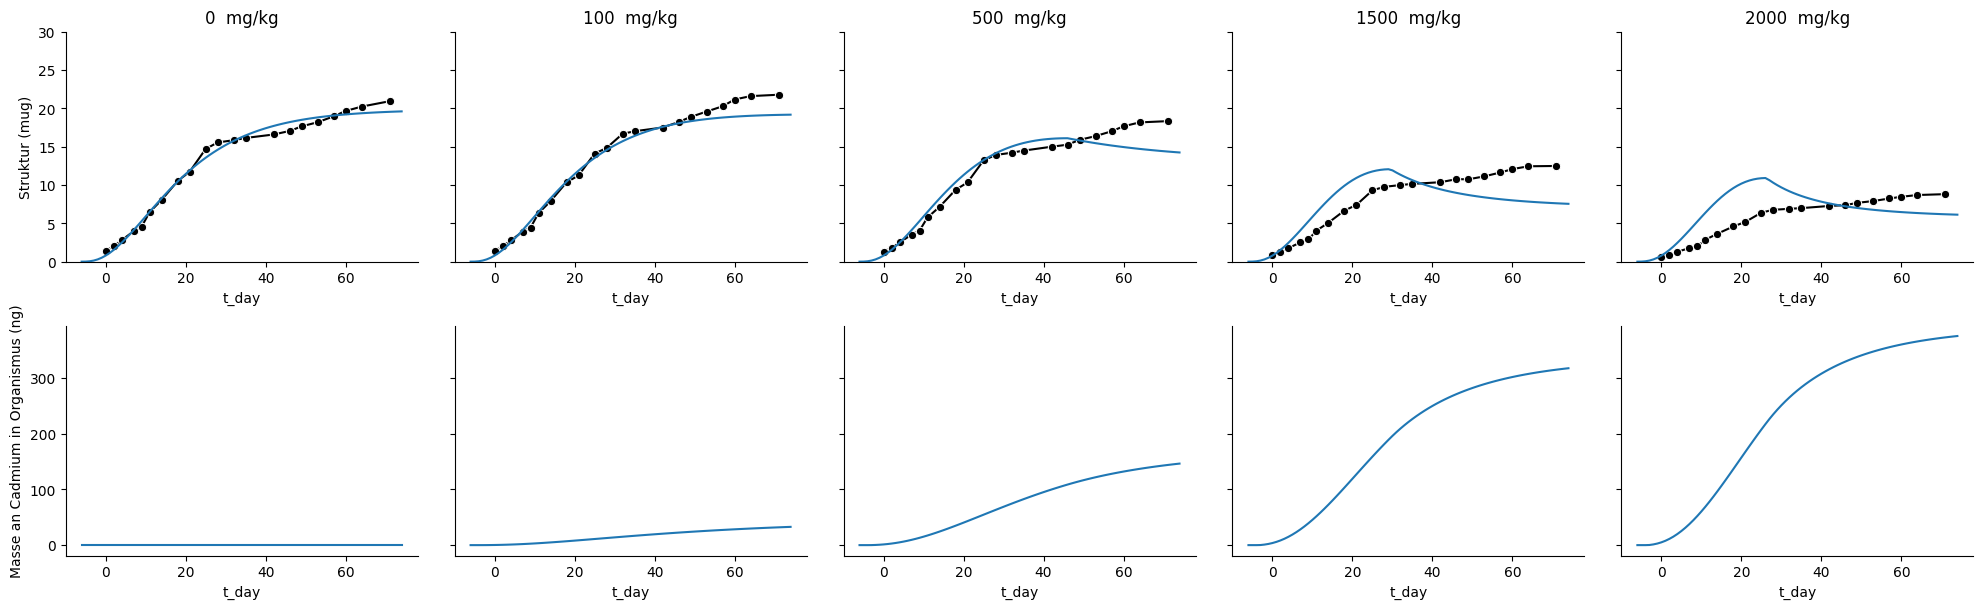

In [19]:
f = setup_modelfit(pmoa = 'M')
f.defaultparams.spc.update(control_fitted_params)
f.intguess = {
        'ex_cd': 0.02,
        'ED50_j' : 1000, 
        'beta_j' : 2, 
        }
sim = f.run_optimization(options={'maxiter' : 10}) # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

## fitting different levels of Cd-exposition from food ingestion/assimilation